<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/HuBMAP_simple_UNet(20230610).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!ls /gdrive/MyDrive/DATA/HuBMAP

annotation_info.csv  masks_grey_bkgrnd	    test	    val_list.csv
images		     masks_white_bkgrnd     test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [4]:
pip install keras-cv --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 13.2 MB/s eta 0:00:00


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm_notebook

import tensorflow as tf
from tensorflow import keras
import keras_cv

from keras.utils import to_categorical
from keras_cv.layers import DropBlock2D
from keras.layers.core import Dropout
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization,SeparableConv2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [6]:
# Make a copy of normalize_he_image.py to current directory
!cp /gdrive/MyDrive/python_modules/normalize_he_image_v2.py .

In [7]:
# import custom module
import normalize_he_image_v2

In [8]:
# Image dimension for train, val and test
image_height = 512
image_width = 512
image_channels = 3
num_classes = 4

In [9]:
annotations_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_info.csv',index_col=0)
annotations_info.head()


blood_vessel  glomerulus  unsure
0006ff2aa7cd             8           1       0
00168d1b7522             1           1       0
0033bbc76b6b             3           0       1
003504460b3a             7           0       0
004daf1cbe75             9           1       0

In [10]:
# Load lists assigned for train, val and test
train_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/train_list.csv',index_col=0)
val_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/val_list.csv',index_col=0)
test_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/test_list.csv',index_col=0)


In [11]:
train_list.head()

train_id
0  18be061202ea
1  29d2f472e46d
2  8f256d18b5e4
3  8e90e6189c6b
4  d850250778f2

In [12]:
# Create and allocate memory for train, val and test images and masks
# Store image ids for each the thress datasets

train_images = np.zeros((len(train_list[:100]),image_height,image_width,image_channels),
                        dtype=np.uint8)
train_masks = np.zeros((len(train_list[:100]),image_height,image_width),dtype=np.uint8)


#val_images = np.zeros((len(val_list),image_height,image_width,image_channels),
#                      dtype=np.uint8)
#val_masks = np.zeros((len(val_list),image_height,image_width),dtype=np.uint8)
#

#test_images = np.zeros((len(test_list),image_height,image_width,image_channels),
#                       dtype=np.uint8)
#test_masks = np.zeros((len(test_list),image_height,image_width),dtype=np.uint8)



In [13]:
np.unique(train_images)

array([0], dtype=uint8)

In [ ]:
#for row in test_list.iterrows():
#  print(row[1]['test_id'])

In [14]:
# Assign path file for images and masks
image_path_file = '/gdrive/MyDrive/DATA/HuBMAP/images/'
mask_path_file = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

In [15]:
# Read images and mask for train dataset(takes about 30-50 min)
for idx, row in tqdm_notebook(enumerate(train_list[:100].iterrows()),total=len(train_list[:100])):
  id  = row[1]['train_id']
  image = cv2.imread(image_path_file + id + '.tif')
  mask = cv2.imread(mask_path_file + id + '_mask.tif',cv2.IMREAD_GRAYSCALE)

  train_images[idx] = image
  train_masks[idx] = mask


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
# Read images and mask for val dataset
for idx, row in tqdm_notebook(enumerate(val_list.iterrows()),total=len(val_list)):
  id  = row[1]['val_id']
  image = cv2.imread(image_path_file + id + '.tif')
  mask = cv2.imread(mask_path_file + id + '_mask.tif',cv2.IMREAD_GRAYSCALE)

  val_images[idx] = image
  val_masks[idx] = mask

  0%|          | 0/156 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
# Read images and mask for test dataset
for idx, row in tqdm_notebook(enumerate(test_list.iterrows()),total=len(test_list)):
  id  = row[1]['test_id']
  image = cv2.imread(image_path_file + id + '.tif')
  mask = cv2.imread(mask_path_file + id + '_mask.tif',cv2.IMREAD_GRAYSCALE)

  test_images[idx] = image
  test_masks[idx] = mask

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
print(train_images.shape)
print(train_masks.shape)
#print(val_images.shape)
#print(val_masks.shape)
#print(test_images.shape)
#print(test_masks.shape)

(100, 512, 512, 3)
(100, 512, 512)


In [18]:
annotations_info.loc[test_list['test_id'],:].sort_values(by='blood_vessel')

blood_vessel  glomerulus  unsure
ba276097772d             0           0       1
ac68833641fe             2           0       4
94288c56b1d3             3           0       0
0a4ddecc55f0             8           1       0
64c675e5750d             9           0       0
954010aca957             9           0       0
bac81a8f8291            11           0       0
d12b5c0f5c0e            13           0       5
ded0fdeaab79            13           1       0
2a9e6a294e2b            20           1       2

In [ ]:
#train_images[show_list[0][0]]

In [19]:
# Display original images from train_images and their respective masks
# Use num to locate selected image from train_iamges
# Use id to locate mask from directory file masks_4d_alt
def display_images_masks(image,id):

  mask_path_file = '/gdrive/MyDrive/DATA/HuBMAP/masks_white_bkgrnd/'

  print(f'Annotation counts for image: {id}: \
  bood vessel: {annotations_info.loc[id,:][0]}, \
  glomerulus: {annotations_info.loc[id,:][1]}, \
  unsure: {annotations_info.loc[id,:][2]}.')

  plt.figure(figsize=(10,10))
  mask = plt.imread(mask_path_file + id + '_mask.tif')

  plt.subplot(1,2,1)
  #plt.imshow(train_images[num])
  plt.imshow(image)
  plt.title(f'Image: {id}')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(mask)
  plt.title(f'Mask: {id}')
  plt.xticks([])
  plt.yticks([])

  plt.show()


Annotation counts for image: af9c61e40ff5:   bood vessel: 4,   glomerulus: 1,   unsure: 3.


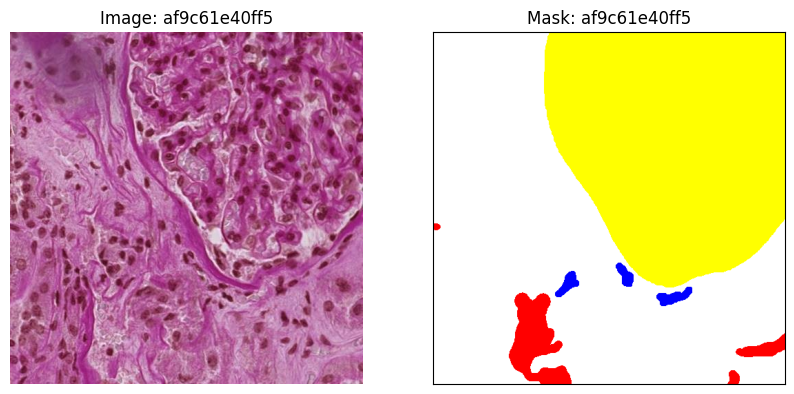

Annotation counts for image: da876b636c6c:   bood vessel: 3,   glomerulus: 0,   unsure: 3.


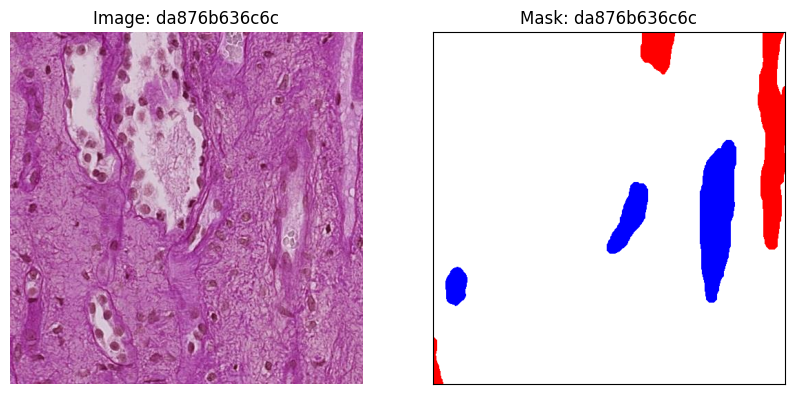

Annotation counts for image: 44c66d51c40e:   bood vessel: 17,   glomerulus: 0,   unsure: 1.


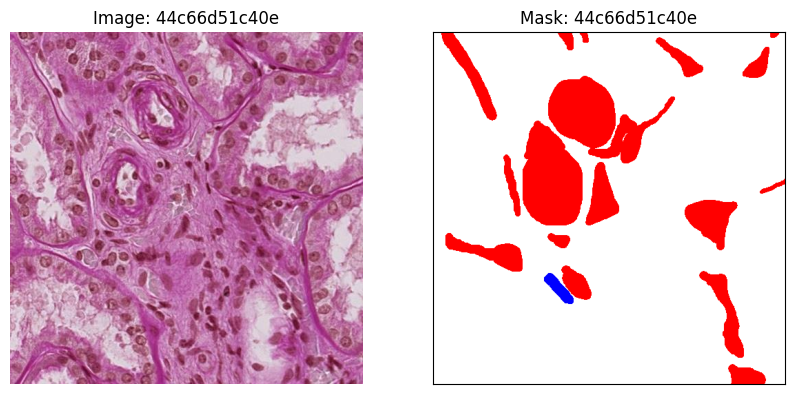

In [20]:
# Display original images and their respective masks
for _ in range(3):
  num = np.random.randint(0,len(train_images))
  id = train_list.loc[num,'train_id']
  image = train_images[num]
  display_images_masks(image,id)

In [217]:
# Python OpenCV: Converting an image to black and white
# https://techtutorialsx.com/2019/04/13/python-opencv-converting-image-to-black-and-white/

# Apply Canny Edge Detection on Image using OpenCV
# https://lindevs.com/apply-canny-edge-detection-on-image-using-opencv
# https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html


# Normalize H&E color for the image
# Also can generated hematoxilyn (h) color separated and eosin (e) color separated
# image
def normalize_image_color(image):

  norm_image,h,e = normalize_he_image_v2.normalize_HnE_stain(image)

  #g = cv2.cvtColor(e,cv2.COLOR_BGR2GRAY)
  #g = np.expand_dims(g,axis=-1)


  return e


In [219]:
# Store normalized H&E color images in separate numpy arrays
train_images_norm = np.zeros((len(train_images[:100]),image_height,image_width,image_channels),
                                 dtype=np.uint8)



#val_images_norm = np.zeros((len(val_images),image_height,image_width,image_channels),
#                                 dtype=np.uint8)

#test_images_norm = np.zeros((len(test_images),image_height,image_width,image_channels),
#                                 dtype=np.uint8)





In [220]:
print(train_images_norm.shape)
#print(val_images_norm.shape)
#print(test_images_norm.shape)

(100, 512, 512, 3)


In [221]:
# Normalize H&E color for the images

for idx in tqdm_notebook(range(len(train_images[:100])),total=len(train_images[:100])):
  train_images_norm[idx] = normalize_image_color(train_images[idx])


#for idx in tqdm_notebook(range(len(val_images)),total=len(val_images)):
#  val_images[idx] = normalize_image_color(val_images[idx])


#for idx in tqdm_notebook(range(len(test_images)),total=len(test_images)):
#  test_images[idx] = normalize_image_color(test_images[idx])

  0%|          | 0/100 [00:00<?, ?it/s]

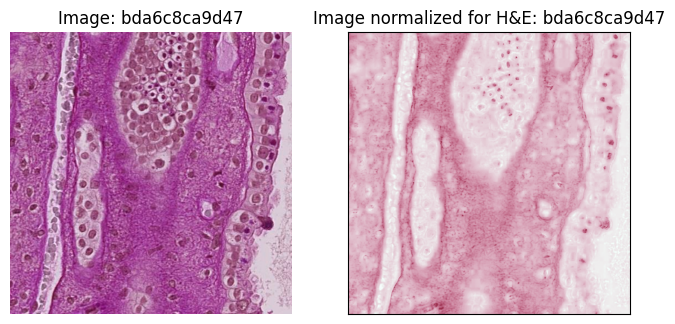

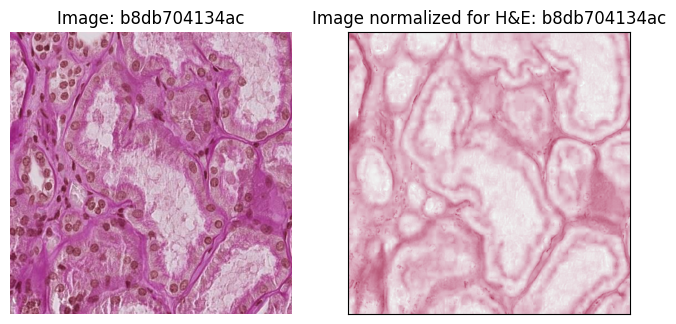

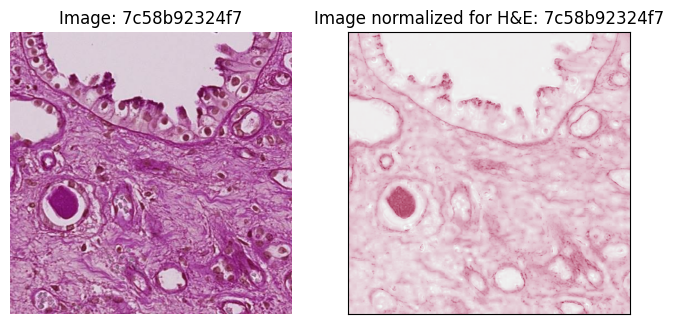

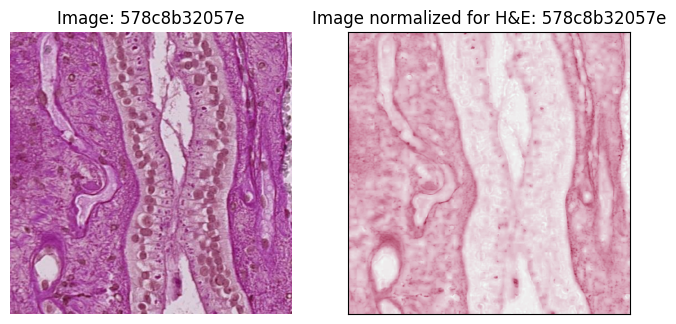

In [222]:
show_img = np.random.randint(0,len(train_images),4)
for num in show_img:
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,1)
  plt.imshow(train_images[num])
  plt.title(f"Image: {train_list.loc[num,'train_id']}")
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(train_images_norm[num],cmap='gray')
  plt.title(f"Image normalized for H&E: {train_list.loc[num,'train_id']}")
  plt.xticks([])
  plt.yticks([])

  plt.show()



In [223]:
train_images_norm.shape

(100, 512, 512, 3)

In [ ]:
#train_images_norm[0]

In [182]:
print(train_masks.shape)
#print(val_masks.shape)
#print(test_masks.shape)

(100, 512, 512)


In [183]:
image_height

512

In [224]:
# Resize image and mask height and width
# and normalize image pixel to 0 to 1
def resize_normalize(image_input,mask_input):

  image_res = cv2.resize(image_input,dsize=(image_height,image_width),
                         interpolation=cv2.INTER_NEAREST)
  mask_res = cv2.resize(mask_input,dsize=(image_height,image_width),
                    interpolation=cv2.INTER_NEAREST)


  image_norm = image_res / 254.  # may need to change this to 254

  #image_norm = np.expand_dims(image_norm,axis=-1) # get rid of this for color images

  return image_norm, mask_res


In [ ]:
#a = train_images_norm[0]/254.

In [ ]:
#np.unique(a)

In [225]:
print(train_masks.shape)
#print(val_masks.shape)
#print(test_masks.shape)

(100, 512, 512)


In [226]:
train_images_norm_res = np.zeros((len(train_images[:100]),image_height,image_width,image_channels),
                                 dtype=np.float64)

In [227]:
train_images_norm_res.shape

(100, 512, 512, 3)

In [228]:
for idx in range(len(train_images_norm)):
  train_images_norm_res[idx],train_masks[idx]= resize_normalize(
      train_images_norm[idx],train_masks[idx])




#for idx in range(len(val_images)):
#  val_images[idx], val_masks[idx] = resize_normalize(
#      val_images[idx],val_masks[idx])


#for idx in range(len(test_images)):
#  test_images[idx], test_masks[idx] = resize_normalize(
#      test_images[idx],test_masks[idx])



In [229]:
print(f'train_images_norm_res min: {train_images_norm_res.min()} & max: {train_images_norm_res.max()}')
#print(f'val_images min: {val_images.min()} & max: {val_images.max()}')
#print(f'test_images min: {test_images.min()} & max: {test_images.max()}')

train_images_norm_res min: 0.003937007874015748 & max: 1.0


In [230]:
np.unique(train_images_norm_res[0])

array([0.01574803, 0.01968504, 0.02362205, 0.03149606, 0.03543307,
       0.03937008, 0.04724409, 0.05511811, 0.05905512, 0.06299213,
       0.07480315, 0.07874016, 0.08661417, 0.09448819, 0.1023622 ,
       0.10629921, 0.11023622, 0.11811024, 0.12598425, 0.12992126,
       0.13385827, 0.13779528, 0.14173228, 0.14566929, 0.1496063 ,
       0.15354331, 0.15748031, 0.16141732, 0.16535433, 0.17322835,
       0.17716535, 0.18110236, 0.18503937, 0.18897638, 0.19291339,
       0.19685039, 0.2007874 , 0.20472441, 0.20866142, 0.21259843,
       0.21653543, 0.22047244, 0.22440945, 0.22834646, 0.23228346,
       0.23622047, 0.24015748, 0.24409449, 0.2480315 , 0.2519685 ,
       0.25590551, 0.25984252, 0.26377953, 0.26771654, 0.27165354,
       0.27559055, 0.27952756, 0.28346457, 0.28740157, 0.29133858,
       0.29527559, 0.2992126 , 0.30314961, 0.30708661, 0.31102362,
       0.31496063, 0.31889764, 0.32283465, 0.32677165, 0.33070866,
       0.33464567, 0.33858268, 0.34251969, 0.34645669, 0.35039

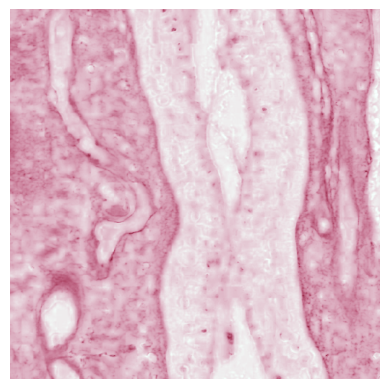

In [232]:
num = np.random.randint(len(train_images_norm_res))
plt.imshow(train_images_norm_res[show_img[3]])
plt.axis('off');

In [233]:
train_images_norm_res.shape
train_masks.shape

(100, 512, 512)

In [234]:
# Expand mask dimension
train_masks_cat = np.expand_dims(train_masks.copy(),axis=-1)
#val_masks = np.expand_dims(val_masks,axis=-1)
#test_masks = np.expand_dims(test_masks,axis=-1)

In [235]:
# Convert masks/labels to categorical (onehot encode)
train_masks_cat = to_categorical(train_masks_cat,num_classes)
#Y_val_cat = to_categorical(val_masks.copy(), num_classes)
#Y_test_cat = to_categorical(test_masks.copy(),num_classes)

In [236]:
print(train_masks_cat.shape)
#print(Y_val_cat.shape)
#print(Y_test_cat.shape)

(100, 512, 512, 4)


In [237]:
# Display image, repective mask and model prediction
def display(data_list):

  #for d in data_list: print(d.dtype)

  plt.figure(figsize=(8,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i],cmap='gray') if i == 0 else plt.imshow(data_list[i])

    if i == 0: plt.axis('off')
    if i == 1 or i == 2: plt.xticks([])
    if i == 1 or i == 2: plt.yticks([])
  plt.tight_layout()
  plt.show()

Image number: 34 and ID: 0e0836cf1824
Annotation counts for image: 0e0836cf1824:   bood vessel: 2,   glomerulus: 0,   unsure: 2.


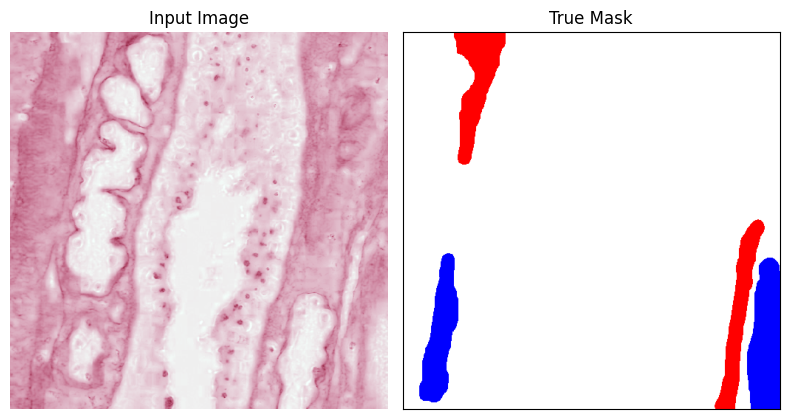

In [238]:
# Diplay image and mask
img_num = np.random.randint(0,len(train_images))
img_id = train_list.loc[img_num,'train_id']

print(f'Image number: {img_num} and ID: {img_id}')
print(f'Annotation counts for image: {img_id}: \
  bood vessel: {annotations_info.loc[img_id,:][0]}, \
  glomerulus: {annotations_info.loc[img_id,:][1]}, \
  unsure: {annotations_info.loc[img_id,:][2]}.')

# Assign an image from validation set to sample_image
mask_w_path_file = '/gdrive/MyDrive/DATA/HuBMAP/masks_white_bkgrnd/'

sample_image = train_images_norm_res[img_num]
sample_mask = plt.imread(mask_w_path_file + img_id + '_mask.tif')

display([sample_image,sample_mask])

In [239]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [91]:
from numpy import asarray

In [240]:
def assign_color_class(mask_input):

  # If mask is not a numpy (some sort tf eagortensor)
  # convert to numpy array - this is for pre-mask
  print(f'A: Mask_input shape: {mask_input.shape} & type: {type(mask_input)}')
  #if type(mask_input) is np.ndarray:
  #  print(f'1: Mask_input is: {type(mask_input)}')
  #  mask_np = mask_input

  #else:
  #  print(f'2: Mask_input is: {type(mask_input)}')
  #  mask_np = np.squeeze(mask_input.numpy(),-1).astype(np.uint8)

  #print(f'B: mask_np shape: {mask_input.shape}')



  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  palette = [255,255,255,     # 0=white
            255,0,0,          # 1= red
            255,255,0,        # 2=yellow
            0,0,255]          # 3=blue

  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(mask_input,'P')
  #pred_pi = pred_pi.putpalette(palette)
  print(f'pred_pi: {mask_pi}')
  # Put the palette in
  mask_pi.putpalette(palette)
  print(f'mask_pi mode: {mask_pi.mode}')
  mask_color_assigned = asarray(mask_pi)
  #mask_color_assigned = np.array(mask_pi.getdata()).reshape(mask_pi.size[0],
  #                                           mask_pi.size[1], 1).astype(np.uint8)

  print(f'3: mask_color_assigned shape: {mask_color_assigned.shape}, type: {type(mask_color_assigned.shape)}')

  return mask_color_assigned



In [241]:
!ls /gdrive/MyDrive/DATA/HuBMAP

annotation_info.csv  masks_grey_bkgrnd	    test	    val_list.csv
images		     masks_white_bkgrnd     test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [242]:
def show_predictions(dataset=None, num=1):
  prediction = current_model.predict(sample_image[tf.newaxis, ...])
  predicted_mask = create_mask(prediction)
  #predicted_mask_ca = assign_color_class(predicted_mask)
  display([sample_image, sample_mask,predicted_mask])



In [243]:
# Display image, mask and prediction mask after each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [244]:
!ls /gdrive/MyDrive/saved_models/HuBMAP/

checkpoint  test_unet.ckpt.data-00000-of-00001	test_unet.ckpt.index


In [245]:
saved_model_filepath = "/gdrive/MyDrive/saved_models/HuBMAP/test_unet.ckpt"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=saved_model_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)


callback_list = [earlystopper,checkpoint,DisplayCallback()]

In [248]:
def get_model():
  inputs = Input((image_height, image_width, image_channels))

  # Downsampling (encodere)
  c1 = Conv2D(filters=8, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Conv2D(filters=8, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (c1)
  bn1 = BatchNormalization()(c1)
  c1 = DropBlock2D(rate=0.05,block_size=int(image_height/2))(bn1)
  # reduce imge
  p1 = MaxPooling2D(pool_size=(2, 2))(c1)

  c2 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (p1)
  c2 = Conv2D(filters=16, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (c2)
  bn2 = BatchNormalization()(c2)
  c2 = DropBlock2D(rate=0.1,block_size=int(image_height/4))(bn2)
  # reduce imge
  p2 = MaxPooling2D(pool_size=(2, 2))(c2)

  c3 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (p2)
  c3 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c3)
  bn3 = BatchNormalization()(c3)
  c3 = DropBlock2D(rate=0.15,block_size=int(image_height/8))(bn3)
  # reduce imge from
  p3 = MaxPooling2D(pool_size=(2, 2))(c3)

  c4 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(p3)
  c4 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c4)
  bn4 = BatchNormalization()(c4)
  c4 = DropBlock2D(rate=0.2,block_size=int(image_height/16))(bn4)
  # reduce imge
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(p4)
  c5 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c5)
  bn5 = BatchNormalization()(c5)
  c5 = DropBlock2D(rate=0.25,block_size=int(image_height/32))(bn5)
  # reduce imge
  p5 = MaxPooling2D(pool_size=(2,2))(c5)

  c6 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(p5)
  c6 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c6)
  bn6 = BatchNormalization()(c6)
  c6 = DropBlock2D(rate=0.25,block_size=int(image_height/64))(bn6)
  # reduce imge
  p6 = MaxPooling2D(pool_size=(2,2))(c6)


  c7 = Conv2D(filters=512, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(p6)
  c7 = Conv2D(filters=512, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c7)
  bn7 = BatchNormalization()(c7)
  c7 = DropBlock2D(rate=0.25,block_size=int(image_height/64))(bn7)

  # upsampling (Decoder)
  u8 = Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2),
                       padding='same')(c7)
  u8 = Concatenate()([u8, c6])
  c8 = Conv2D(filters=256, kernel_size=(3, 3),activation='elu',
              kernel_initializer='he_normal', padding='same')(u8)
  c8 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c8)
  bn8 = BatchNormalization()(c8)
  c8 = DropBlock2D(rate=0.25,block_size=int(image_height/64))(bn8)

  u9 = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2),
                       padding='same')(c8)
  u9 = Concatenate()([u9, c5])
  c9 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(u9)
  c9 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c9)
  bn9 = BatchNormalization()(c9)
  c9 = DropBlock2D(rate=0.25,block_size=int(image_height/32))(bn9)

  u10 = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2),
                       padding='same')(c9)
  u10 = Concatenate()([u10, c4])
  c10 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (u10)
  c10 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same') (c10)
  bn10 = BatchNormalization()(c10)
  c10 = DropBlock2D(rate=0.20,block_size=int(image_height/16))(bn10)

  u11 = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2),
                       padding='same')(c10)
  u11 = Concatenate()([u11,c3])
  c11 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(u11)
  c11 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu',
              kernel_initializer='he_normal', padding='same')(c11)
  bn11 = BatchNormalization()(c11)
  c11 = DropBlock2D(rate=0.15,block_size=int(image_height/8))(bn11)

  u12 = Conv2DTranspose(filters=16,kernel_size=(2,2),strides=(2,2),
                       padding='same')(c11)
  u12 = Concatenate()([u12,c2])
  c12 = Conv2D(filters=16,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(u12)
  c12 = Conv2D(filters=16,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(c12)
  bn12 = BatchNormalization()(c12)
  c12 = DropBlock2D(rate=0.10,block_size=int(image_height/4))(bn12)

  u13 = Conv2DTranspose(filters=8,kernel_size=(2,2),strides=(2,2),
                       padding='same')(c12)
  u13 = Concatenate()([u13,c1])
  c13 = Conv2D(filters=8,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(u13)
  c13 = Conv2D(filters=8,kernel_size=(3,3),activation='elu',
              kernel_initializer='he_normal',padding='same')(c13)
  bn13 = BatchNormalization()(c13)
  c13 = DropBlock2D(rate=0.05,block_size=int(image_height/2))(bn13)


  # Last / top layer
  outputs = Conv2D(filters=4, kernel_size=(1, 1),activation='softmax')(c13)


  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [249]:
current_model = get_model()

1/1 [==============================] - 0s 476ms/step


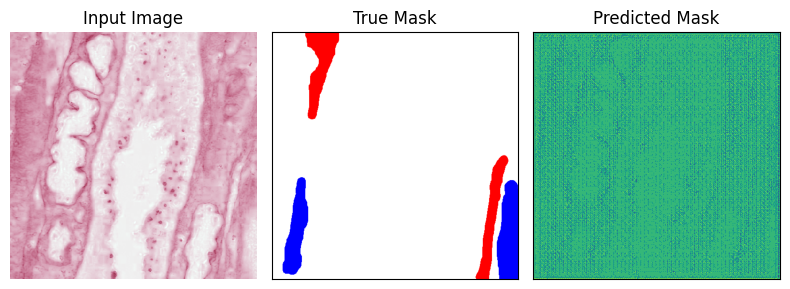

In [250]:
show_predictions()

In [251]:
# Reusable model parameters
activation_input_1 = 'softmax'


LR = 0.0001

optim_input = keras.optimizers.Adam(learning_rate=LR)


# Use Jaccard and categorical focal loss
loss_input = tf.keras.losses.CategoricalCrossentropy()

metrics_input = [tf.keras.metrics.MeanIoU(num_classes=num_classes,
                                    sparse_y_pred = False,
                                    sparse_y_true= False)]

In [252]:
current_model.compile(optimizer=optim_input,
                      loss=loss_input,
                      metrics=metrics_input)

In [253]:
train_images_norm_res.shape

(100, 512, 512, 3)

1/1 [==============================] - 0s 26ms/step


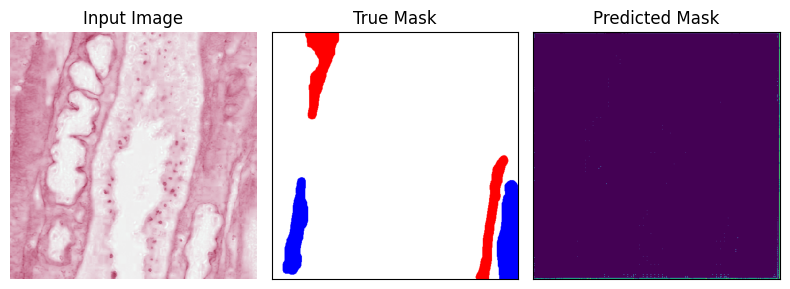


Sample Prediction after epoch 26

4/4 [==============================] - 16s 4s/step - loss: 1.3508 - mean_io_u_6: 0.1585 - val_loss: 0.8762 - val_mean_io_u_6: 0.2290
Epoch 26: early stopping


In [254]:
# Pre-train model
history = current_model.fit(train_images_norm_res[:80],
            train_masks_cat[:80],
            batch_size=20,
            epochs=30,
            verbose=1,
            validation_data=(train_images_norm_res[80:],train_masks_cat[80:]),
            callbacks=callback_list)

In [255]:
history.history.keys()

dict_keys(['loss', 'mean_io_u_6', 'val_loss', 'val_mean_io_u_6'])

In [257]:
history.history['val_mean_io_u_6']

[0.034543730318546295,
 0.04786509647965431,
 0.07077337056398392,
 0.09584089368581772,
 0.12159327417612076,
 0.15008018910884857,
 0.16533495485782623,
 0.17541609704494476,
 0.17728014290332794,
 0.1765429973602295,
 0.1757933348417282,
 0.17529690265655518,
 0.1750705987215042,
 0.17489172518253326,
 0.17604678869247437,
 0.17814815044403076,
 0.1804068684577942,
 0.19016216695308685,
 0.1915370374917984,
 0.20092922449111938,
 0.20209261775016785,
 0.22149689495563507,
 0.22915694117546082,
 0.22919169068336487,
 0.22904573380947113,
 0.22897185385227203]

In [258]:
current_model.predict()

InvalidArgumentError: ignored